In [1]:
#Import Packages

from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
#Read in GeoJSONs with Geopandas

plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")
earthquakes_gdf = gpd.read_file("MR_Data/earthquakes.GeoJSON")
volcanoes_gdf = gpd.read_file("MR_Data/volcanoes.GeoJSON")
vents_gdf = gpd.read_file("MR_Data/vents.GeoJSON")

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
earthquakes_gdf.plot(ax=ax, markersize = 25, column = "Magnitude", cmap = "rainbow", marker = "x")
volcanoes_gdf.plot(ax=ax, markersize = 25, column = "Type", cmap = "rainbow", marker = "^")
vents_gdf.plot(ax=ax, markersize = 25, column = "Depth", cmap = "rainbow", marker = "|")

earthquakes_gdf

volcanoes_gdf.head(1)

vents_gdf.head(1)

eruptions = pd.read_table("MR_Data/volerup.txt")

#eruptions
eruptions.info()

eruptions = eruptions.drop(["TOTAL_HOUSES_DESTROYED_DESCRIPTION", "TOTAL_HOUSES_DESTROYED", "TOTAL_DAMAGE_DESCRIPTION", 
                            "TOTAL_DAMAGE_MILLIONS_DOLLARS", "TOTAL_INJURIES_DESCRIPTION", "TOTAL_INJURIES", 
                            "TOTAL_MISSING_DESCRIPTION", "TOTAL_MISSING", "TOTAL_DEATHS_DESCRIPTION", 
                            "HOUSES_DESTROYED_DESCRIPTION", "HOUSES_DESTROYED", "DAMAGE_DESCRIPTION", 
                            "DAMAGE_MILLIONS_DOLLARS", "INJURIES_DESCRIPTION", "INJURIES", "MISSING_DESCRIPTION", 
                            "MISSING", "DEATHS_DESCRIPTION", "DEATHS", "Agent"], axis = 1)
#geometry_erupt = [Point(xy) for xy in zip(eruptions.Longitude, eruptions.Latitude)]
#crs = {"init": "epsg:4326"} 
#eruptions_gdf = gpd.GeoDataFrame(eruptions, crs=crs, geometry=geometry_erupt)

eruptions_gdf

def web_scraper(url, class_):
    request = urllib.request.Request(url)
    result = urllib.request.urlopen(request)
    resulttext = result.read()
    soup = BS(resulttext, 'html.parser')
    table = soup.find_all('table', class_=class_)
    table_2 = table[0]
    table_headers = table_2.find_all("th")
    columns = [th.text for th in table_headers]
    rows = []
    for tr in table_2.find_all("tr")[1:]:
        row_data = [td.text for td in tr.find_all("td")]
        rows.append(row_data)
    return pd.DataFrame(rows, columns = columns)

earthquakes_2 = WebScraper(
    "https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900", 
    "sortable wikitable", earthquakes_2)
print(earthquakes_2)

request = urllib.request.Request("https://en.wikipedia.org/wiki/List_of_large_volcanic_eruptions_of_the_20th_century")
result = urllib.request.urlopen(request)
resulttext = result.read()
soup = BS(resulttext, 'html.parser')
table = soup.find_all('table', class_="wikitable sortable")
table_2 = table[0]
#table_2
table_headers = table_2.find_all("th")[1:5]
#table_headers
columns = [th.text for th in table_headers]
rows = []
for tr in table_2.find_all("tr")[1:]:
    row_data = [td.text for td in tr.find_all("td")]
    rows.append(row_data)
eruptions_2 = pd.DataFrame(rows, columns = columns)

test = "(\[\d+\])"
eruptions_2["Volcano (eruption)"] = eruptions_2["Volcano (eruption)"].str.replace(test, "")
eruptions_2.columns = ["Name", "Year", "Casualties", "Notes"]
eruptions_2.head()

#volcanoes_gdf.info()
#cols = ["Country", "Type", "lat", "lng", "Elevation", "geometry"]
volcanoes_2 = volcanoes_gdf.drop(["Country", "Type", "Elevation", "geometry"], axis = 1)
volcanoes_2.columns = ["Name", "lat", "lng"]

volcanoes["lat"] = volcanoes["lat"].astype(str)
volcanoes["lng"] = volcanoes["lng"].astype(str)

volcanoes.info()

eruptions_2.info()

eruptions_2["Name"] = eruptions_2["Name"].str.strip()

eruptions_2[eruptions_2["Name"].str.contains("Alaid")]

volcanoes_2[volcanoes_2["Name"].str.contains("Alaid")]

#eruptions_new["lat"] = volcanoes_2["Name"].map(volcanoes_2.set_index("Name")["lat"])
eruptions_new = eruptions_2.merge(volcanoes_2, how = "left", on = "Name")
eruptions_new_notnull = eruptions_new[eruptions_new["lat"].notnull()]
#len(eruptions_new_notnull)
#eruptions_new
eruptions_new_notnull

geometry_erupt_new = [Point(xy) for xy in zip(eruptions_new.lng, eruptions_new.lat)]
crs = {"init": "epsg:4326"}
eruptions_new_gdf = gpd.GeoDataFrame(eruptions_new, crs=crs, geometry=geometry_erupt_new)
eruptions_new_gdf

request = urllib.request.Request("https://en.wikipedia.org/wiki/List_of_submarine_volcanoes")
result = urllib.request.urlopen(request)
resulttext = result.read()
soup = BS(resulttext, 'html.parser')
table = soup.find_all('table', class_="wikitable sortable")
table_2 = table[0]
#table_2
table_headers = table_2.find_all("th")
#table_headers
columns = [th.text for th in table_headers]
rows = []
for tr in table_2.find_all("tr")[1:]:
    row_data = [td.text for td in tr.find_all("td")]
    rows.append(row_data)
submarine = pd.DataFrame(rows, columns = columns)

submarine

spade = "(\d*♠)"
submarine["Summit Elevation"]=submarine["Summit Elevation"].str.replace(spade, "")
submarine["Approximate elevation above seafloor"]=submarine["Approximate elevation above seafloor"].str.replace(spade, "")

submarine

coord_ms = "(.*/.*/)"
submarine["Location"]=submarine["Location"].str.replace(coord_ms, "")

submarine

submarine[['lat','lng']] = submarine['Location'].str.split(';',expand=True)

submarine["lat"] = submarine["lat"].str.strip()
submarine["lng"] = submarine["lng"].str.strip()
submarine["lat"] = pd.to_numeric(submarine["lat"])
submarine["lng"] = pd.to_numeric(submarine["lng"])

submarine

geometry_sub = [Point(xy) for xy in zip(submarine.lng, submarine.lat)]
crs = {"init": "epsg:4326"}
submarine_gdf = gpd.GeoDataFrame(submarine, crs=crs, geometry=geometry_sub)
submarine_gdf.head(1)

submarine_gdf.plot()

#encoding for "utf-8"
#tsunamis = pd.read_table("MR_Data/tsevent.txt", encoding = "ISO-8859-1")

In [3]:
tsunamis_2 = pd.read_csv("MR_Data/tsunamis.csv")
tsunamis_2 = tsunamis_2.drop("Unnamed: 0", axis = 1)
tsunamis_2.columns = ["Year", "Month", "Day", "Focal_Depth", "Magnitude", "Country", "Location", "lat", "lng", "Max_Water_Height", "Deaths", "Total_Deaths"]
tsunamis_2 = tsunamis_2.drop(0)
#tsunamis_2
#tsunamis_2["lat"] = pd.to_numeric(tsunamis_2["lat"])
#tsunamis_2["lng"] = pd.to_numeric(tsunamis_2["lng"])
#geometry_t = [Point(xy) for xy in zip(tsunamis_2.lng, tsunamis_2.lat)]
#crs = {"init": "epsg:4326"}
#tsunamis_gdf = gpd.GeoDataFrame(tsunamis_2, crs=crs, geometry=geometry_t)
#tsunamis_gdf.head()

DD = d + (min/60) + (sec/3600)

fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
#earthquakes_gdf.plot(ax=ax, markersize = 25, column = "Magnitude", cmap = "rainbow", marker = "x")
#volcanoes_gdf.plot(ax=ax, markersize = 5, color = "red") #, column = "Type", cmap = "rainbow", marker = "^")
#vents_gdf.plot(ax=ax, markersize = 25, column = "Depth", cmap = "rainbow", marker = "|")
#eruptions_gdf.plot(ax=ax, markersize = 5, color = "orange") #, column = "Elevation", cmap = "rainbow", marker = "^")
#submarine_gdf.plot(ax=ax, markersize = 15, color = "green")
#eruptions_new_gdf.plot(ax=ax, markersize = 5, color = "b")
tsunamis_gdf.plot(ax=ax, markersize = 5, color = "purple")

earthquakes_gdf.head(1)

volcanoes_gdf.head(1)

submarine_gdf.head(1)

eruptions_gdf.head(1)

eruptions_new_gdf.head(1)

tsunamis_gdf.head(1)

vents_gdf.head(1)

columns to drop:
Tsunamis = ["Country", "Location", :"Max_Water_Height"]
Vents = ["Name", "Activity", "Region", "Year&Discovered"]
Eruptions_new = ["Notes"]
Eruptions = ["Location", "Country", "Elevation", "Status", "Time"]

dfs to concat:
submarine and volcanoes

Things to fix:

Merge between eruptions_2 and volcanoes.

In [4]:
earthquakes2_gdf = gpd.read_file("MR_Data/earthquakes2.GeoJSON")
eruptions_more_gdf = gpd.read_file("MR_Data/geoserver-GetFeature.application")

In [5]:
earthquakes2_gdf.head(1)

,date,depth,mag,id,place,geometry
0,19600102,15.0,6.3,iscgem877909,Bouvet Island region,POINT (-1.89 -55.877)


In [6]:
lat = []
lng = []
for point in earthquakes2_gdf["geometry"]:
    lng.append(point.x)
    lat.append(point.y)
#lat

In [7]:
earthquakes2 = earthquakes2_gdf.drop(["geometry", "place", "id"], axis = 1)
earthquakes2["lat"] = lat
earthquakes2["lng"] = lng
earthquakes2.head(15)

,date,depth,mag,lat,lng
0,19600102,15.0,6.3,-55.877,-1.890
1,19600103,15.0,5.7,43.700,84.542
2,19600104,15.0,6.1,11.374,42.609
3,19600107,55.0,5.5,6.352,94.547
4,19600107,15.0,5.6,6.418,94.756
5,19600107,35.0,6.2,-55.591,-27.278
6,19600108,35.0,6.0,-55.585,-27.475
7,19600108,15.0,5.9,-55.570,-27.115
8,19600111,15.0,5.6,16.046,95.832
9,19600112,10.0,5.8,23.401,122.323


In [8]:
earthquakes2["date"] = earthquakes2["date"].apply(str)
year = "(\d\d\d\d)"
month = "(\d\d)"
earthquakes2["year"] = earthquakes2["date"].str.extract(year, expand = True)
earthquakes2["date"] = earthquakes2["date"].str[4:]
earthquakes2["month"] = earthquakes2["date"].str.extract(month, expand = True)
earthquakes2["date"] = earthquakes2["date"].str[2:]
earthquakes2.columns = ["Day", "Depth", "Mag", "lat", "lng", "Year", "Month"]
earthquakes2 = earthquakes2[["Year", "Month", "Day", "lat", "lng", "Mag", "Depth"]]
earthquakes2.head()
#for date in earthquakes2["date"]:
#    year_md = [date[i:i+4] for i in range(0, len(date), 4)]

#year_md

,Year,Month,Day,lat,lng,Mag,Depth
0,1960,01,02,-55.877,-1.890,6.3,15.0
1,1960,01,03,43.700,84.542,5.7,15.0
2,1960,01,04,11.374,42.609,6.1,15.0
3,1960,01,07,6.352,94.547,5.5,55.0
4,1960,01,07,6.418,94.756,5.6,15.0


In [9]:
eruptions_more_gdf2 = eruptions_more_gdf.drop(["id", "VolcanoName", "VolcanoNumber", "StartDate", "EndDate", "Activity_ID", "geometry"], axis = 1)
eruptions = pd.DataFrame(eruptions_more_gdf2)
eruptions.head(1)

,ExplosivityIndexMax,StartDateYear,StartDateMonth,StartDateDay,EndDateYear,EndDateMonth,EndDateDay,ContinuingEruption,LatitudeDecimal,LongitudeDecimal
0,2,1934,2,2,2017.0,11.0,1.0,True,38.789,15.213


In [10]:
eruptions.columns = ["ExplosivityIndexMax", "Year", "Month", "Day", "End_Year", "End_Month", "End_Day", "Continuing", "lat", "lng"]
eruptions = eruptions[["Year", "Month", "Day", "lat", "lng", "ExplosivityIndexMax", "End_Year", "End_Month", "End_Day", "Continuing"]]
eruptions.head()

,Year,Month,Day,lat,lng,ExplosivityIndexMax,End_Year,End_Month,End_Day,Continuing
0,1934,2,2,38.789,15.213,2,2017.0,11.0,1.0,True
1,2010,8,25,37.748,14.999,1,2013.0,4.0,27.0,False
2,2013,9,3,37.748,14.999,2,2017.0,11.0,16.0,True
3,2004,9,7,37.748,14.999,1,2005.0,3.0,8.0,False
4,2005,12,16,37.748,14.999,1,2005.0,12.0,22.0,False


In [11]:
tsunamis_2 = tsunamis_2.drop(["Country", "Location"], axis = 1)
tsunamis_2 = tsunamis_2[["Year", "Month", "Day", "lat", "lng", "Magnitude", "Focal_Depth", "Max_Water_Height", "Deaths", "Total_Deaths"]]
#tsunamis_2.head()
tsunamis_2.shape

(2610, 10)

In [12]:
tsunamis_2[tsunamis_2["lat"].isnull()]

,Year,Month,Day,lat,lng,Magnitude,Focal_Depth,Max_Water_Height,Deaths,Total_Deaths
5,-760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,-150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,-138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,765,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,799,9,18,NaN,NaN,NaN,NaN,2,NaN,NaN
82,855,6,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
86,881,4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
tsunamis_3 = tsunamis_2.drop(tsunamis_2[tsunamis_2["lat"].isnull()].index)

In [14]:
tsunamis_3.head(100)

,Year,Month,Day,lat,lng,Magnitude,Focal_Depth,Max_Water_Height,Deaths,Total_Deaths
1,-2000,NaN,NaN,35.683,35.8,NaN,NaN,NaN,NaN,NaN
2,-1610,NaN,NaN,36.4,25.4,NaN,NaN,90,NaN,NaN
3,-1365,NaN,NaN,35.683,35.8,NaN,NaN,NaN,NaN,NaN
4,-1300,NaN,NaN,39.96,26.24,6,NaN,NaN,NaN,NaN
6,-590,NaN,NaN,33.27,35.22,NaN,NaN,NaN,NaN,NaN
7,-525,NaN,NaN,33.56,35.37,NaN,NaN,NaN,NaN,NaN
8,-480,9,29,37.9,23.5,NaN,NaN,NaN,NaN,NaN
9,-479,NaN,NaN,39.7,23.3,7,NaN,NaN,NaN,NaN
10,-426,6,NaN,38.9,22.7,7.1,NaN,NaN,NaN,2500
11,-373,NaN,NaN,38.25,22.25,7.3,NaN,NaN,NaN,NaN


In [15]:
#tsunamis_3[tsunamis_3["Year"]=="1900"]
tsunamis_4 = tsunamis_3[tsunamis_3.index>=1345]
tsunamis_4
#tsunamis_3[tsunamis_3.index>=1344]

,Year,Month,Day,lat,lng,Magnitude,Focal_Depth,Max_Water_Height,Deaths,Total_Deaths
1345,1900,1,10,1.82,127.85,NaN,NaN,NaN,NaN,NaN
1346,1900,8,11,58.6,-137.5,NaN,NaN,NaN,5,5
1347,1900,9,10,-4,152,6.8,NaN,NaN,NaN,NaN
1348,1900,9,17,-5,148,NaN,NaN,3,NaN,NaN
1349,1900,10,7,-4,140,6.9,NaN,NaN,5,5
1350,1900,10,29,11,-66,8.4,25,10,NaN,NaN
1351,1901,3,3,36,-120.5,6.7,NaN,NaN,NaN,NaN
1352,1901,3,31,43.4,28.5,7.2,NaN,3,NaN,4
1353,1901,6,15,39,143,6,33,NaN,NaN,NaN
1354,1901,6,24,28,130.3,7.5,33,0.25,NaN,NaN


In [16]:
earthquakes2.to_json("JSONs_for_TP/earthquakes2.json")
eruptions.to_json("JSONs_for_TP/eruptions.json")
tsunamis_4.to_json("JSONs_for_TP/tsunamis.json")

In [17]:
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

boundaries_gdf

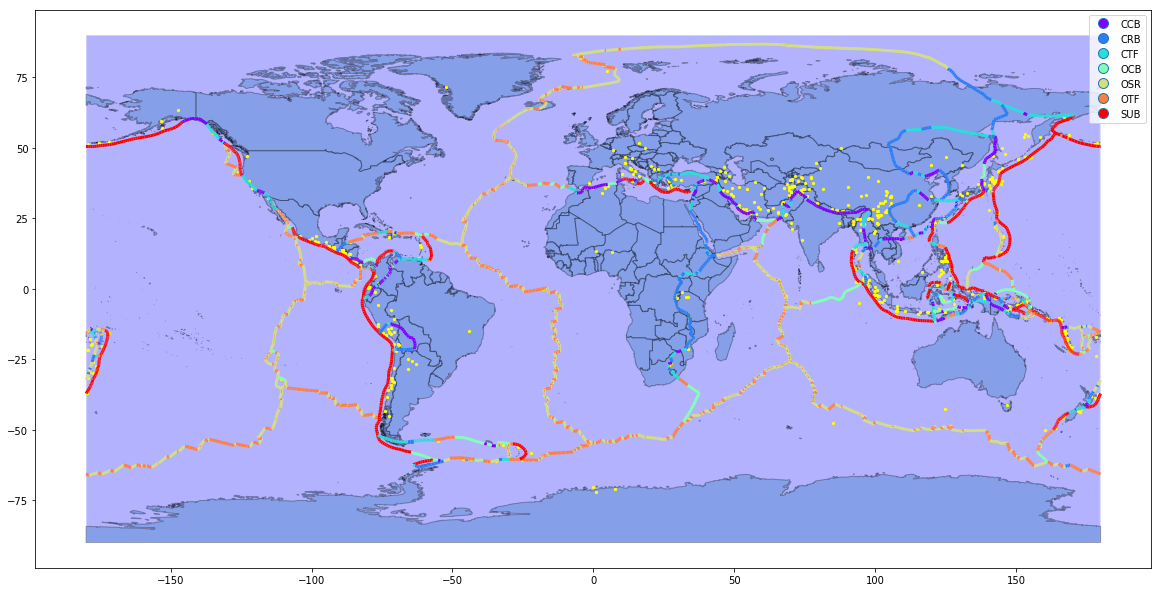

In [19]:
#earthquakes2_gdf
#volcanoes2_gdf
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
#earthquakes2_gdf.plot(ax=ax, markersize = 5, color = "blue")
#eruptions_new_gdf.plot(ax=ax, markersize = 5, color = "orange")
#eruptions_gdf.plot(ax=ax, markersize = 5, color = "green")
#tsunamis_gdf.plot(ax=ax, markersize = 5, color = "yellow")
boundaries_gdf.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 3, legend = True)
#vents_gdf.plot(ax=ax, markersize = 5, color = "blue")
#eruptions_more_gdf.plot(ax=ax, markersize = 5, color = "yellow")
earthquakes_gdf.plot(ax=ax, markersize = 5, color = "yellow")

In [20]:
boundaries_sub = boundaries_gdf[boundaries_gdf["STEPCLASS"] == "SUB"]
#boundaries_sub

,SEQNUM,STARTLONG,STARTLAT,FINALLONG,FINALLAT,PLATEBOUND,BOUNDCONT,STEPLENGTH,AZIMUTHCEN,VELOCITYLE,VELOCITYAZ,VELOCITYDI,VELOCITYRI,ELEVATION,SEAFLOORAG,STEPCLASS,STEPCONTIN,OROGEN,geometry
398,399.0,10.373,38.685,10.609,38.821,EU\AF,FALSE,25.4,54.0,7.2,155.0,-7.1,-1.5,-2221.0,260.0,SUB,FALSE,TRUE,"LINESTRING (10.373 38.685, 10.38206 38.69024, ..."
399,400.0,10.609,38.821,10.827,38.994,EU\AF,TRUE,27.0,44.0,7.3,155.0,-6.8,-2.6,-2569.0,260.0,SUB,TRUE,TRUE,"LINESTRING (10.609 38.821, 10.617055 38.827415..."
400,401.0,10.827,38.994,11.118,39.067,EU\AF,TRUE,26.4,72.0,7.3,156.0,-7.3,0.8,-2418.0,260.0,SUB,TRUE,TRUE,"LINESTRING (10.827 38.994, 10.837767 38.996717..."
401,402.0,11.118,39.067,11.363,39.075,EU\AF,TRUE,21.2,88.0,7.4,156.0,-6.8,2.7,-2335.0,260.0,SUB,TRUE,TRUE,"LINESTRING (11.118 39.067, 11.129135 39.067375..."
402,403.0,11.363,39.075,11.659,39.033,EU\AF,TRUE,26.0,100.0,7.4,156.0,-6.1,4.2,-2420.0,260.0,SUB,TRUE,TRUE,"LINESTRING (11.363 39.075, 11.373969 39.073458..."
403,404.0,11.659,39.033,11.778,38.934,EU\AF,TRUE,15.0,137.0,7.4,156.0,-2.5,7.0,-2233.0,260.0,SUB,TRUE,TRUE,"LINESTRING (11.659 39.033, 11.666447 39.026816..."
404,405.0,11.778,38.934,12.057,38.878,EU\AF,TRUE,25.0,105.0,7.5,157.0,-5.9,4.6,-2308.0,260.0,SUB,TRUE,TRUE,"LINESTRING (11.778 38.934, 11.789168 38.931773..."
405,406.0,12.057,38.878,12.434,38.849,EU\AF,TRUE,32.7,96.0,7.5,157.0,-6.6,3.6,-2208.0,260.0,SUB,TRUE,TRUE,"LINESTRING (12.057 38.878, 12.068429 38.877139..."
406,407.0,12.434,38.849,12.708,38.600,EU\AF,TRUE,36.4,139.0,7.5,158.0,-2.4,7.1,-1725.0,260.0,SUB,TRUE,TRUE,"LINESTRING (12.434 38.849, 12.44143 38.842279,..."
407,408.0,12.708,38.600,13.314,38.611,EU\AF,TRUE,52.7,89.0,7.6,158.0,-7.1,2.6,-1557.0,260.0,SUB,TRUE,TRUE,"LINESTRING (12.708 38.6, 12.719432 38.600237, ..."


#from shapely.geometry import shape#, MultiLineString
#multi_line_sub = MultiLineString(boundaries_sub[boundaries_sub["geometry"]])

#points = earthquakes2_gdf.unary_union.intersection(boundaries_sub.unary_union)
#points

#intersections= gpd.sjoin(earthquakes2_gdf, boundaries_sub, how="inner", op='intersects')
#intersections

#the_lines = [shape(line['geometry']) for line in boundaries_sub]
#the_points = [shape(point['geometry']) for point in earthquakes2_gdf]
#the_lines

union_test = boundaries_sub.unary_union
union_test

union_test_eqs = earthquakes2_gdf.unary_union
union_test_eqs

overlap_test = union_test_eqs.intersects(union_test)
overlap_test

intersections = []
for line in boundaries_sub["geometry"]:
    intersections.append(line.intersection(earthquakes2_gdf["geometry"]))
                         
intersections

In [21]:
earthquakes_gdf = earthquakes_gdf.drop(earthquakes_gdf[earthquakes_gdf["geometry"].isnull()].index)
#earthquakes_gdf[earthquakes_gdf["geometry"].isnull()]

,Country,Date,Deaths,Lat,Long,Magnitude,geometry


In [22]:
earthquakes_geo = earthquakes_gdf["geometry"]
#print(type(earthquakes_geo))
sub_geo = boundaries_sub["geometry"]
#print(type(sub_geo))
boundaries_geo = boundaries_gdf["geometry"]
#print(type(boundaries_geo))

<class 'geopandas.geoseries.GeoSeries'>
<class 'geopandas.geoseries.GeoSeries'>
<class 'geopandas.geoseries.GeoSeries'>


plt.hist(earthquakes_gdf["min_dist_to_lines"], bins = 500)

earthquakes_sub = earthquakes_gdf[earthquakes_gdf["min_dist_to_lines"]<=1.08598896e+00]

def min_distance(point, lines):
    return lines.distance(point).min()

earthquakes_gdf['min_dist_to_lines_2'] = earthquakes_gdf.geometry.apply(min_distance, boundaries_sub)

In [32]:
min_dist = np.empty(len(earthquakes_gdf))
for i, point in enumerate(earthquakes_geo):
    min_dist[i] = np.min([point.distance(line) for line in boundaries_geo])
earthquakes_gdf['min_dist_to_lines'] = min_dist
#earthquakes_gdf

In [33]:
min_dist = np.empty(len(earthquakes_gdf))
for i, point in enumerate(earthquakes_geo):
    min_dist[i] = np.min([point.distance(line) for line in sub_geo])
earthquakes_gdf['min_dist_to_lines_sub'] = min_dist
#earthquakes_gdf

In [34]:
earthquakes_sub = earthquakes_gdf[earthquakes_gdf["min_dist_to_lines"] == earthquakes_gdf["min_dist_to_lines_sub"]]

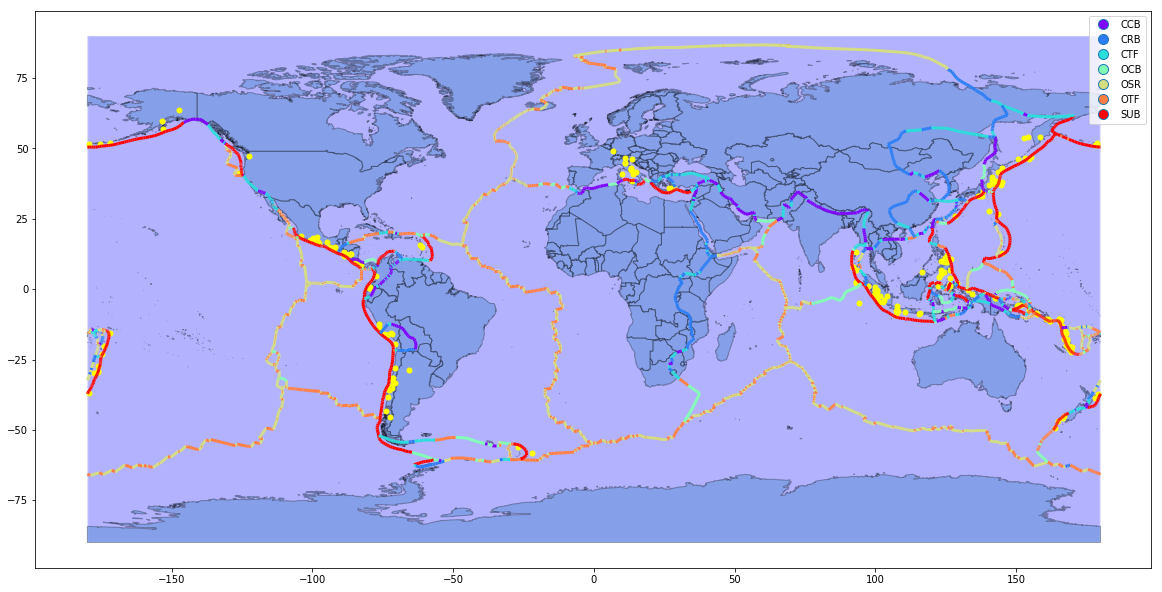

In [35]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha = 0.3, lw = 2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha = 0.3)
boundaries_gdf.plot(ax=ax, column = "STEPCLASS", cmap = "rainbow", lw = 3, legend = True)
earthquakes_sub.plot(ax=ax, markersize = 25, color = "yellow")